# Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns

# Data Manipulation

In [3]:
#reading data
data = pd.read_csv("~/OneDrive/Documents/Datakind/DC DHS/Data/InShelterPerDay.csv")
data['date'] = pd.to_datetime(data['date'])
data = data[data['Total']!=0]
#data[['MinTempF','MaxTempF', 'SnowIn', 'PrecipIn', 'FreezingAtEntry', 'Total']] = data[['MinTempF','MaxTempF', 'SnowIn', 'PrecipIn', 'FreezingAtEntry', 'Total']].fillna(0)
#data = data.dropna()
data.head()

,date,Total,dayWeek,month,day,year,MinTempF,MaxTempF,SnowIn,PrecipIn,FreezingAtEntry
0,2005-01-01,393,7,1,1,2005,39.92,59.00,0.0,0.000000,0.0
1,2005-01-02,451,1,1,2,2005,39.92,68.00,0.0,0.000000,0.0
2,2005-01-03,466,2,1,3,2005,39.92,46.94,0.0,0.000000,0.0
3,2005-01-04,469,3,1,4,2005,42.08,64.04,0.0,0.031496,0.0
4,2005-01-05,498,4,1,5,2005,46.94,69.08,0.0,0.181102,0.0


In [4]:
#filtering out data
data = data[~data['year'].isin([2005, 2021])]

# Correlation Analysis

<AxesSubplot:>

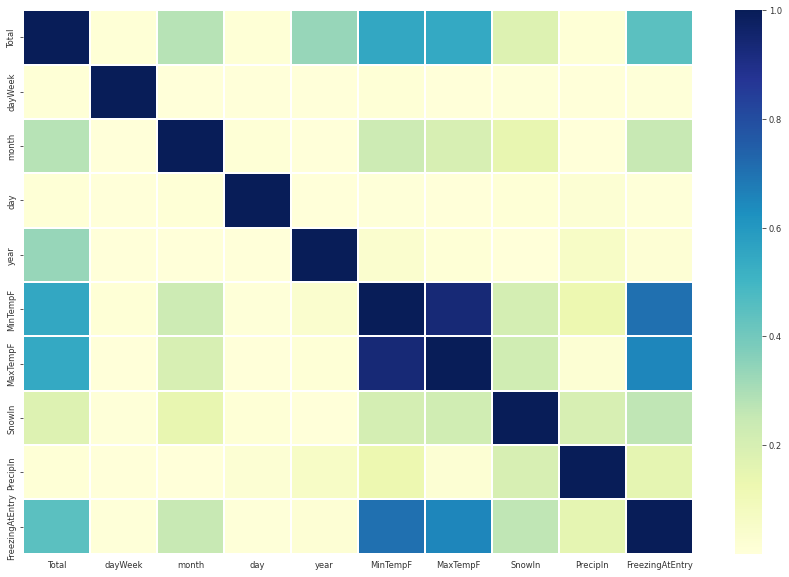

In [6]:
corrmat = data.corr(method = 'spearman')
f,ax = plt.subplots(figsize = (15,10))
sns.heatmap(abs(corrmat), ax = ax , cmap = 'YlGnBu', linewidth = 0.1)

# Multivariate Analysis

In [6]:
# Create a TimeSeries, specifying the time and value columns
model_data = data[['date', 'Total', 'MinTempF', 'PrecipIn','FreezingAtEntry']].reset_index().fillna(0)
X_train, X_test, y_train, y_test = train_test_split(model_data[['date', 'MinTempF', 'PrecipIn','FreezingAtEntry']] ,model_data['Total'], test_size=0.33,  shuffle=False)

In [56]:
# fitting model
params = {
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': {'l2', 'l1'},
                'learning_rate': 0.05,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': 0,
                'max_depth' : 5
            }
         
lgb_train = lgb.Dataset(X_train[['MinTempF', 'PrecipIn','FreezingAtEntry']], y_train)
gbm = lgb.train(params,lgb_train,num_boost_round=500)

forecast = list(gbm.predict(X_train[['MinTempF', 'PrecipIn','FreezingAtEntry']], num_iteration=gbm.best_iteration))
final1 = pd.DataFrame()
final1['date'] = X_train['date']
final1['Total'] = y_train
final1 = final1.reset_index()
final1['Forecast'] = forecast

forecast = list(gbm.predict(X_test[['MinTempF', 'PrecipIn','FreezingAtEntry']], num_iteration=gbm.best_iteration))
final2 = pd.DataFrame()
final2['date'] = X_test['date']
final2['Total'] = y_test
final2 = final2.reset_index()
final2['Forecast'] = forecast

final = final1.append(final2)
final = final.reset_index()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

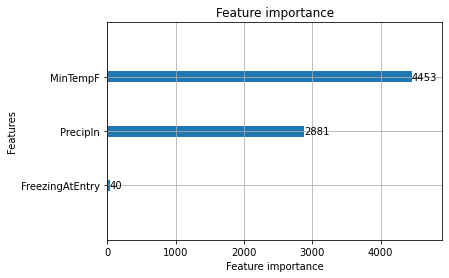

In [60]:
lgb.plot_importance(gbm)

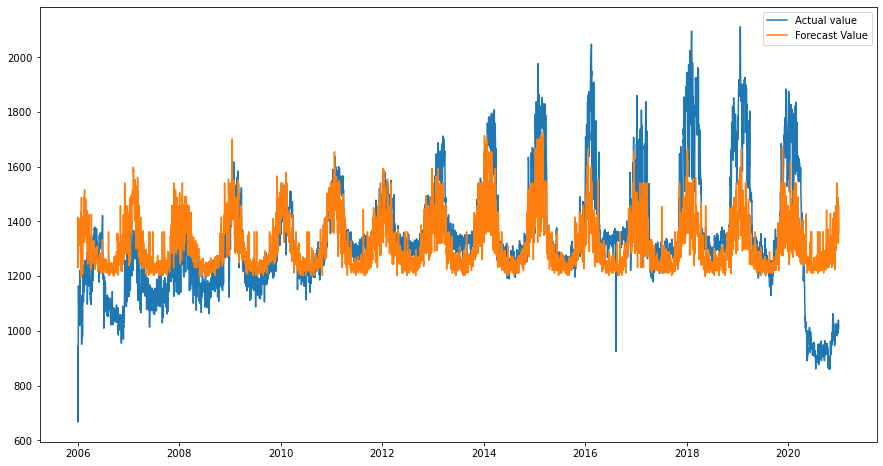

In [57]:
# plotting data
plt.figure(figsize=(15,8))
plt.plot(final.date, final.Total,label='Actual value')
plt.plot(final.date, final.Forecast,label='Forecast Value')
plt.legend()
plt.show()